# Kidney Stone Classication using CT_Images

## Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
import random
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2 
from skimage.feature import hog 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
# import gradio as gr

## Preparing Traning Data

In [2]:
folder_path = "CT_Images/Train"
filenames = []
categories = []

for category in os.listdir(folder_path):
    category_path = os.path.join(folder_path, category)
    
    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            filenames.append(os.path.join(category, filename))
            categories.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [3]:
df.head()

,filename,category
0,Normal\Normal- (1).jpg,Normal
1,Normal\Normal- (10).jpg,Normal
2,Normal\Normal- (100).jpg,Normal
3,Normal\Normal- (1000).jpg,Normal
4,Normal\Normal- (101).jpg,Normal


In [4]:
df.tail()

,filename,category
2995,Stone\Stone- (995).jpg,Stone
2996,Stone\Stone- (996).jpg,Stone
2997,Stone\Stone- (997).jpg,Stone
2998,Stone\Stone- (998).jpg,Stone
2999,Stone\Stone- (999).jpg,Stone


<Axes: xlabel='category'>

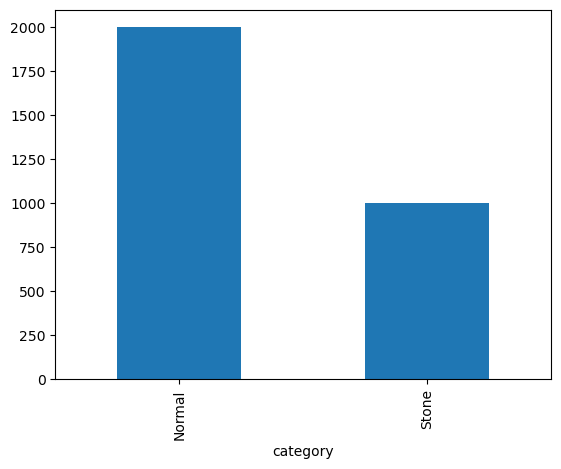

In [5]:
df['category'].value_counts().plot.bar()

We have 3000 total images (2000 Normal, 1000 Stone)

## Visualizing Data

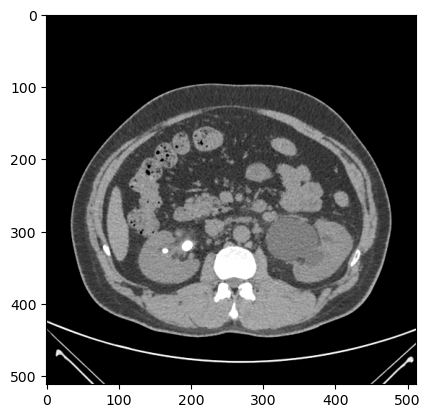

In [6]:
sample = random.choice(filenames)
image = load_img("CT_Images/Train/"+sample)
plt.imshow(image)

# CNN(Convolutional Neural Network)

## Building CNN Model

In [7]:
model = Sequential()

#Adding convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#Adding a second convolutional layer
model.add(Conv2D(64, (3, 3) , activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  # this converts our feature maps to 1D feature vectors
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2)) # as we have binary class i.e stone and normal so value is 2
model.add(Activation('sigmoid')) #sigmoid for binary class classification

C:\Users\Binisha\Desktop\ml\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 198, 198, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 198, 198, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 99, 99, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 97, 97, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 97, 97, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 147456)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      18,874,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,895,042 (72.08 MB)

 Trainable params: 18,894,594 (72.08 MB)

 Non-trainable params: 448 (1.75 KB)

### Call Backs

#### Early Stop
To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [9]:
earlystop = EarlyStopping(patience=10)

#### Learning Rate Reduction
We will reduce the learning rate when then accuracy not increase for 2 steps

In [10]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [11]:
callbacks = [earlystop, learning_rate_reduction]

### Preparing Data

In [12]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

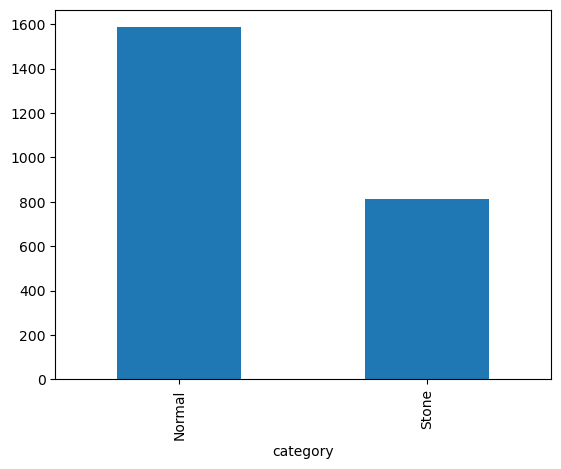

In [13]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

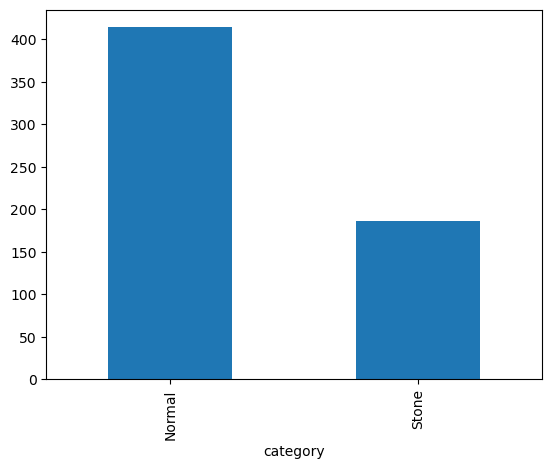

In [14]:
validate_df['category'].value_counts().plot.bar()

### Train and Validation generator

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "CT_Images/Train/", 
    x_col='filename',
    y_col='category',
    target_size=(200,200),
    class_mode='categorical',
    batch_size=15,
    shuffle=True
)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "CT_Images/Train/", 
    x_col='filename',
    y_col='category',
    target_size=(200,200),
    class_mode='categorical',
    batch_size=15
)

Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


In [17]:
# Function to yield data from the generator
def generate_data(generator):
    while True:
        yield from generator

# Create TensorFlow datasets with repeat
train_dataset = tensorflow.data.Dataset.from_generator(
    lambda: generate_data(train_generator),
    output_signature=(
        tensorflow.TensorSpec(shape=(None, 200, 200, 3), dtype=tensorflow.float32),
        tensorflow.TensorSpec(shape=(None, 2), dtype=tensorflow.float32)
    )
).repeat()  # Repeat indefinitely

validation_dataset = tensorflow.data.Dataset.from_generator(
    lambda: generate_data(validation_generator),
    output_signature=(
        tensorflow.TensorSpec(shape=(None, 200, 200, 3), dtype=tensorflow.float32),
        tensorflow.TensorSpec(shape=(None, 2), dtype=tensorflow.float32)
    )
).repeat()

### Visulaizing the output of data gen

In [18]:
example_df = train_df.sample(n=5).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "CT_Images/Train/", 
    x_col='filename',
    y_col='category',
    target_size=(200,200),
    class_mode='categorical',
)

Found 5 validated image filenames belonging to 1 classes.


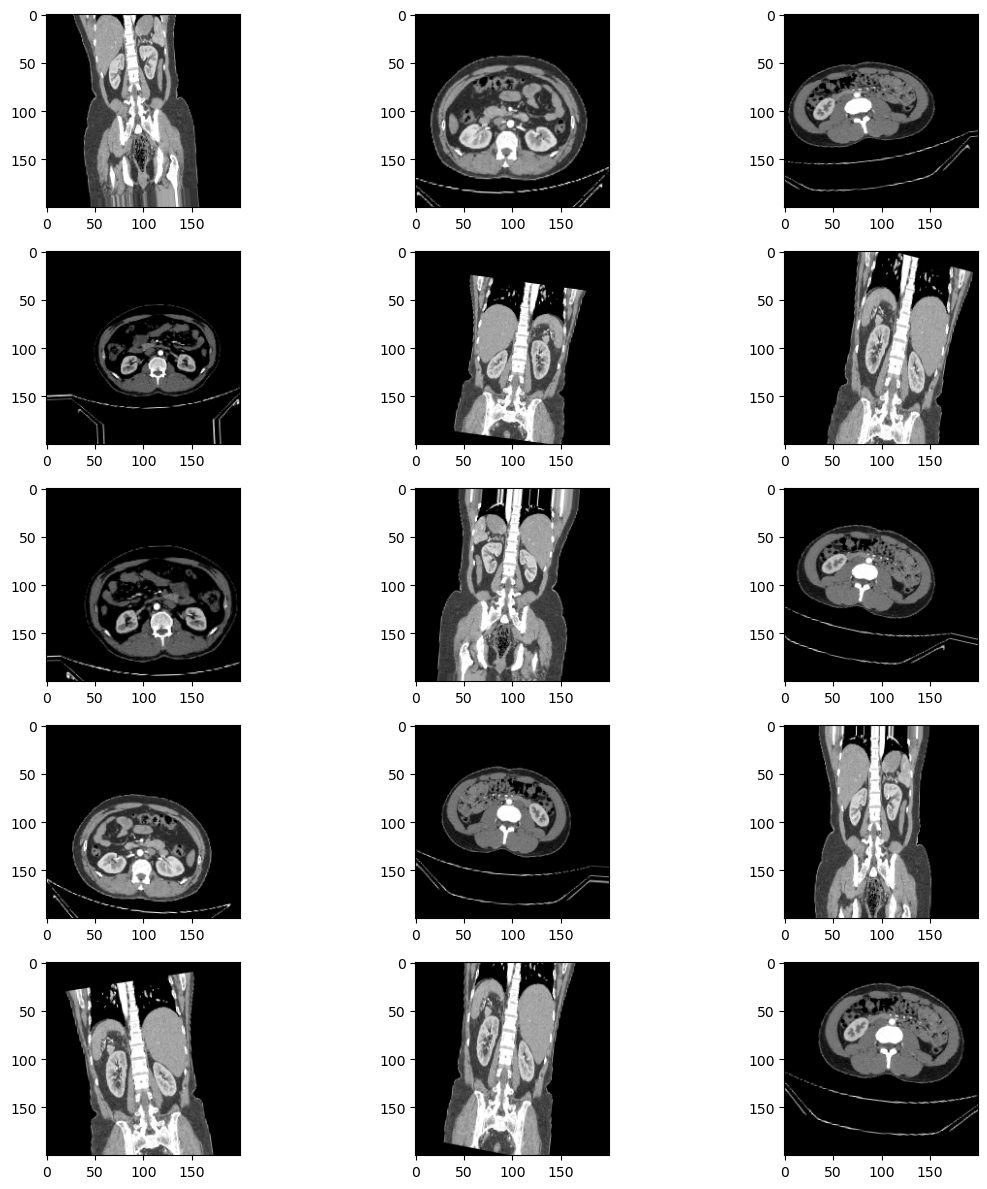

In [19]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

### Fitting the Model

In [20]:
# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [21]:
history = model.fit(
    train_dataset, 
    epochs=50,
    validation_data=validation_dataset,
    validation_steps=validate_df.shape[0]//15,
    steps_per_epoch=train_df.shape[0]//15,
    callbacks=callbacks,
)

Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.6721 - loss: 0.7478 - val_accuracy: 0.4867 - val_loss: 0.9447 - learning_rate: 0.0010
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.8254 - loss: 0.4122 - val_accuracy: 0.6517 - val_loss: 0.9571 - learning_rate: 0.0010
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.8733 - loss: 0.3225 - val_accuracy: 0.8333 - val_loss: 0.4215 - learning_rate: 0.0010
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.8728 - loss: 0.3215 - val_accuracy: 0.9217 - val_loss: 0.2313 - learning_rate: 0.0010
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.8939 - loss: 0.2571 - val_accuracy: 0.9667 - val_loss: 0.1095 - learning_rate: 0.0010
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.9145 - loss: 0.2306 - val_accuracy: 0.9117 - val_loss: 0.2362 - learning_rate: 0.0010
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.9230 - loss: 0

### Visualizing the Training history

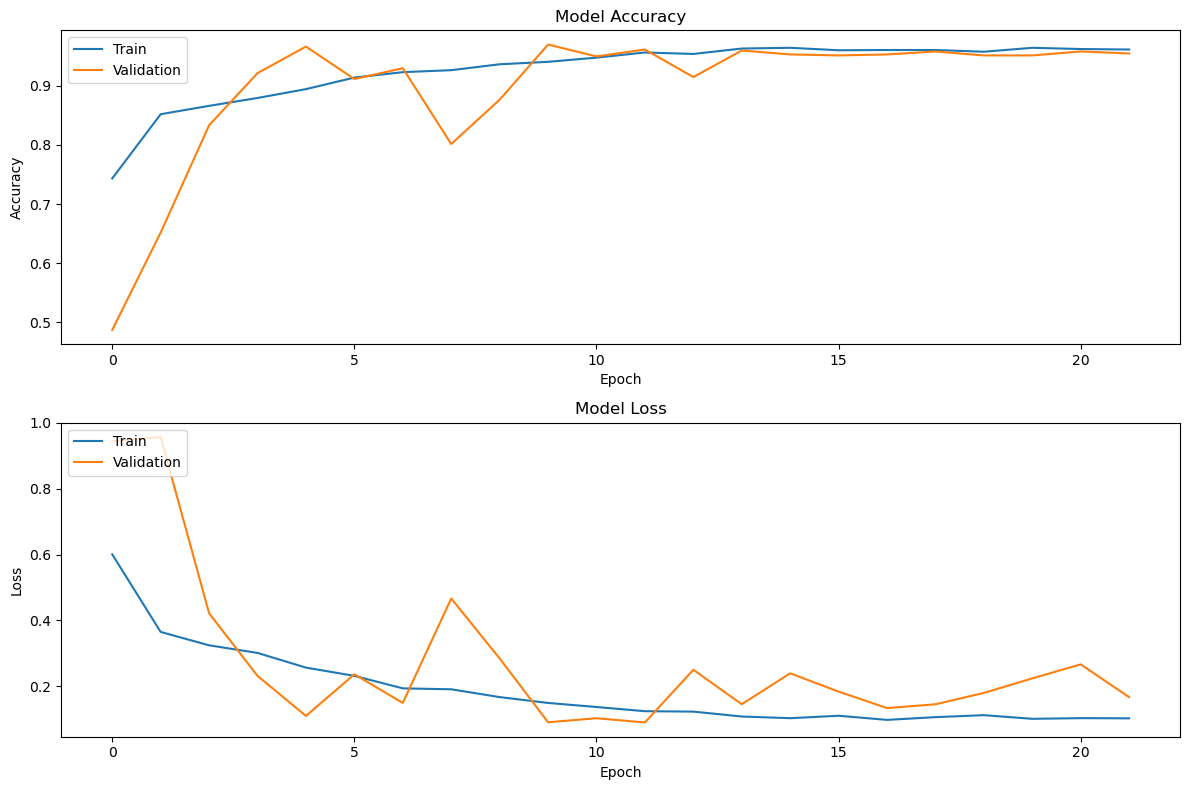

In [22]:
# Plotting the training history
plt.figure(figsize=(12, 8)) 

# Plot training & validation accuracy values
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### Saving the CNN Model

In [23]:
# Saving the Model
model.save('kidney_stone_detection_CT_image_model_200.h5')

### Testing Data

In [24]:
test_folder_path = "CT_Images/Test"
test_filenames = []
test_categories = []

for category in os.listdir(test_folder_path):
    test_category_path = os.path.join(test_folder_path, category)
    
    if os.path.isdir(test_category_path):
        for filename in os.listdir(test_category_path):
            test_filenames.append(os.path.join(category, filename))
            test_categories.append(category)

test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})

In [25]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "CT_Images/Test/", 
    x_col='filename',
    y_col='category',
    target_size=(200,200),
    class_mode='categorical',
    batch_size=15,
    shuffle=False
)

Found 900 validated image filenames belonging to 2 classes.


### Predictions

In [26]:
steps = int(np.ceil(test_df.shape[0] / 15))

predict = model.predict(test_generator, steps=steps)

C:\Users\Binisha\Desktop\ml\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 243ms/step


In [27]:
test_df['predicted category'] = np.argmax(predict, axis=-1)

In [28]:
test_df['predicted category'] = test_df['predicted category'].replace({ 1: 'Stone', 0: 'Normal' })

In [29]:
test_df.head()

,filename,category,predicted category
0,Normal\Normal- (1001).jpg,Normal,Normal
1,Normal\Normal- (1002).jpg,Normal,Normal
2,Normal\Normal- (1003).jpg,Normal,Normal
3,Normal\Normal- (1004).jpg,Normal,Normal
4,Normal\Normal- (1005).jpg,Normal,Normal


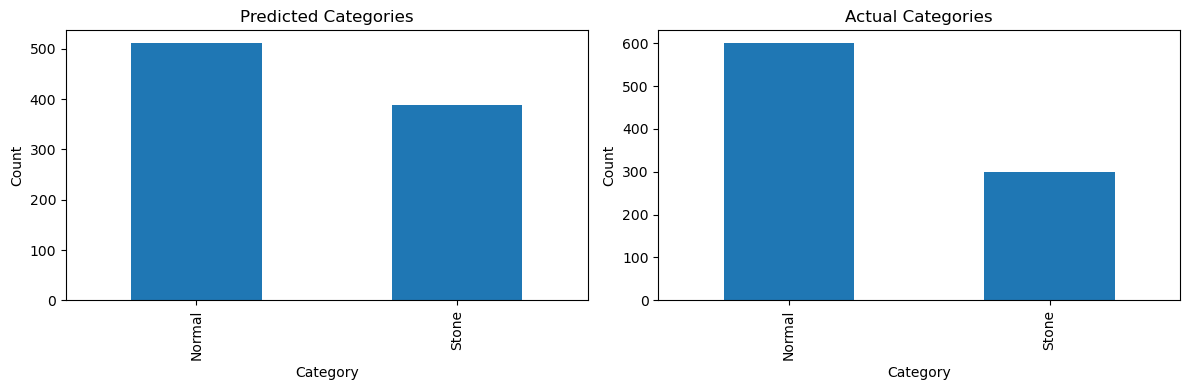

In [30]:
plt.figure(figsize=(12, 4))

# Plot the first bar plot (predicted category)
plt.subplot(1, 2, 1)
test_df['predicted category'].value_counts().plot.bar()
plt.title('Predicted Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Plot the second bar plot (actual category)
plt.subplot(1, 2, 2)
test_df['category'].value_counts().plot.bar()
plt.title('Actual Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Assuming 'Stone' is the positive class
print('Precision:', precision_score(test_df['category'], test_df['predicted category'], pos_label='Stone'))
print('Recall:', recall_score(test_df['category'], test_df['predicted category'], pos_label='Stone'))
print('F1 Score:', f1_score(test_df['category'], test_df['predicted category'], pos_label='Stone'))
print(classification_report(test_df['category'], test_df['predicted category']))

Precision: 0.7377892030848329
Recall: 0.9566666666666667
F1 Score: 0.8330914368650217
              precision    recall  f1-score   support

      Normal       0.97      0.83      0.90       600
       Stone       0.74      0.96      0.83       300

    accuracy                           0.87       900
   macro avg       0.86      0.89      0.86       900
weighted avg       0.90      0.87      0.88       900



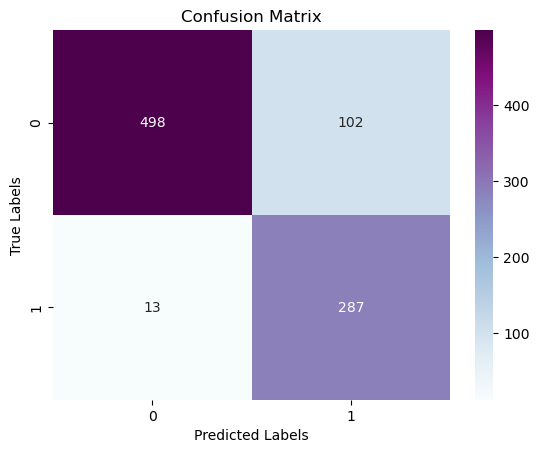

In [32]:
cm = confusion_matrix(test_df['category'], test_df['predicted category'])

sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

The results is baised toward normal as we have more Normal Images 

In [33]:
model.evaluate(test_generator)

60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 206ms/step - accuracy: 0.8883 - loss: 0.4187


[0.4565606713294983, 0.8722222447395325]

# Prediction with user input

In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import random

In [35]:
model = load_model('kidney_stone_detection_CT_image_model_200.h5')

In [36]:
def predict_image(image_path):
    """
    Predicts if a CT scan image is 'Normal' or 'Stone'.
    
    Parameters:
    - image_path (str): Path to the CT scan image.
    
    Returns:
    - str: 'Normal' or 'Stone' based on the prediction.
    """
    # Load and preprocess the image
    image = load_img(image_path, target_size=(200, 200))  # Resize to match model's input size
    image = img_to_array(image) / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    
    # Make a prediction
    prediction = model.predict(image)
    print(prediction[0][0])
    #   [0][0]= no stone prob  [0][1]= stone prob
    if prediction[0][1] > 0.5:
        return 'Kidney Stone Detected (Positive)',round(prediction[0][1]*100,2),'%'
    else:
        return 'No Kidney Stone Detected  (Negative)',round(prediction[0][0]*100,2),'%'

In [ ]:
user_image_path = input("Enter the path to your CT scan image: ")
if os.path.exists(user_image_path):
    result = predict_image(user_image_path)
    print(f"The uploaded CT scan image is classified as: {result}")
else:
    print("File not found. Please check the path and try again.")